# Computing the scattering matrix of an optical device 

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

This notebook will give a demo of the `Tidy3D` [ComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.ComponentModeler.html) plugin used to compute scattering matrix elements.

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np

# tidy3D imports
import tidy3d as td
from tidy3d import web

## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
lambda_range = np.linspace(1.5, 1.6, 40)
freqs = td.constants.C_0 / lambda_range
fwidth = freq0 / 10  # for the source

# Spatial grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=14, wavelength=lambda0)

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.5
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# length of coupling region (um)
coup_length = 5.0
# spacing between waveguides in coupling region (um)
wg_spacing_coup = 0.07
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# Straight waveguide sections on each side
straight_wg_length = 4
# space between waveguide and PML
pml_spacing = 1.2

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup

### Create Base Simulation

The scattering matrix tool requires the "base" [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) (without the modal sources or monitors used to compute S-parameters), so we will construct that now.

We generate the structures and add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html?highlight=FieldMonitor) so we can inspect the field patterns.

In [4]:
# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = gdstk.Cell("Coupler")

substrate = gdstk.rectangle(
    (-device_length / 2, -wg_spacing_in / 2 - 10),
    (device_length / 2, wg_spacing_in / 2 + 10),
    layer=0,
)
coup_cell.add(substrate)

# Add the coupler to a GDS cell
gds_coup = make_coupler(
    device_length, wg_spacing_in, wg_width, wg_spacing_coup, coup_length, bend_length
)
coup_cell.add(gds_coup)

# Substrate
(oxide_geo,) = td.PolySlab.from_gds(
    gds_cell=coup_cell, gds_layer=0, gds_dtype=0, slab_bounds=(-10, 0), axis=2
)

oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

# Waveguides (import all datatypes if gds_dtype not specified)
coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
    gds_cell=coup_cell, gds_layer=1, slab_bounds=(0, wg_height), axis=2
)

coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)

coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

# Simulation size along propagation direction
sim_length = 2 * straight_wg_length + 2 * bend_length + coup_length

# Spacing between waveguides and PML
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2 * pml_spacing,
    wg_height + 2 * pml_spacing,
]

# source
src_pos = sim_length / 2 - straight_wg_length / 2

# in-plane field monitor (optional, increases required data storage)
domain_monitor = td.FieldMonitor(
    center=[0, 0, wg_height / 2], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

# initialize the simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[oxide, coupler1, coupler2],
    sources=[],
    monitors=[domain_monitor],
    run_time=50 / fwidth,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

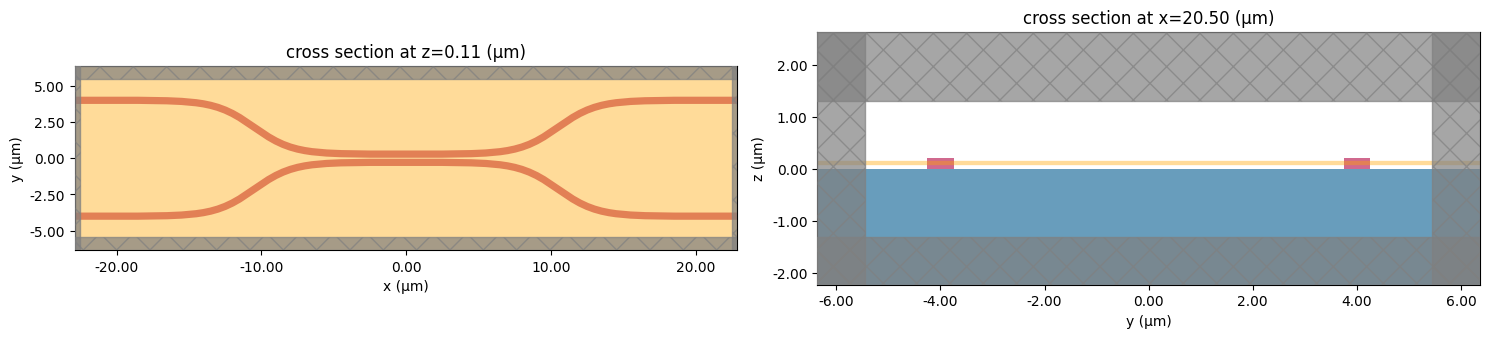

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z=wg_height / 2, ax=ax1)
ax2 = sim.plot(x=src_pos, ax=ax2)

## Setting up the Scattering Matrix Tool
Now, to use the S matrix tool, we need to define the spatial extent of the "ports" of our system using [Port](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.Port.html) objects.

These ports will be converted into modal sources and monitors later, so they require both some mode specification and a definition of the direction that points into the system.

We'll also give them names to refer to later.

In [6]:
from tidy3d.plugins.smatrix import Port

num_modes = 1

port_right_top = Port(
    center=[src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="-",
    name="right_top",
)

port_right_bot = Port(
    center=[src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="-",
    name="right_bot",
)

port_left_top = Port(
    center=[-src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="+",
    name="left_top",
)

port_left_bot = Port(
    center=[-src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="+",
    name="left_bot",
)

ports = [port_right_top, port_right_bot, port_left_top, port_left_bot]

Next, we will add the base simulation and ports to the [ComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.ComponentModeler.html), along with the frequency of interest and a name for saving the batch of simulations that will get created later.

In [7]:
from tidy3d.plugins.smatrix import ModalComponentModeler

modeler = ModalComponentModeler(
    simulation=sim,
    ports=ports,
    freqs=freqs,
)

We can plot the simulation with all of the ports as sources to check things are set up correctly.

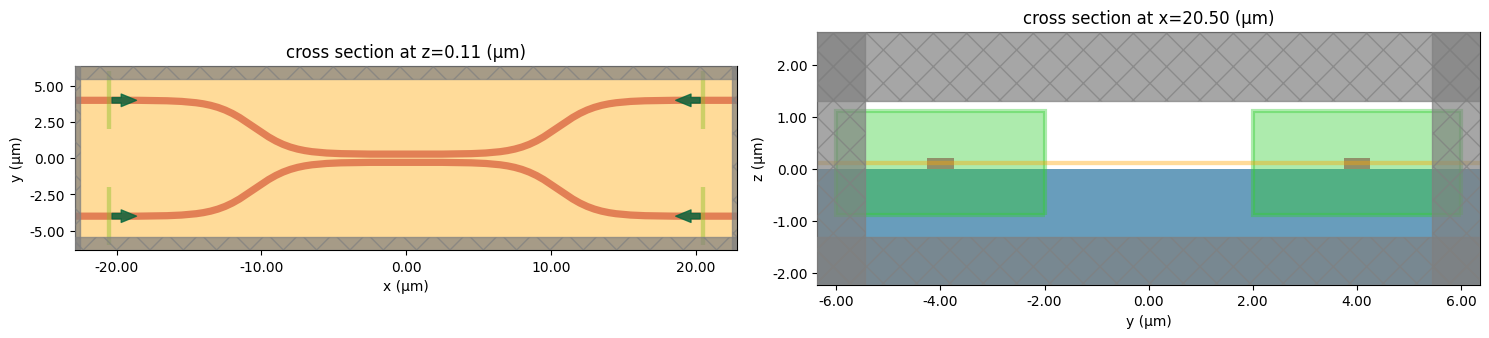

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=wg_height / 2, ax=ax1)
ax2 = modeler.plot_sim(x=src_pos, ax=ax2)

## Solving for the S matrix

With the component modeler defined, we can use the usual `web` functions to `run` the batch of simulations needed to compute the S matrix. The tool will loop through each port and create one simulation per mode index (as defined by the mode specifications) where a unique modal source is injected. Each of the ports will also be converted to mode monitors to measure the mode amplitudes and normalization. The simulations run asynchronously in a batch, and the final post-processing step assembles all the data into a single [ModalComponentModelerData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModalComponentModelerData.html) object.

In [9]:
modeler_data = web.run(modeler, task_name="directional coupler", verbose=True)

09:53:12 EDT Created task 'directional coupler' with resource_id                
             'sid-9ffb7196-975e-42c0-af2e-ead76927cc4c' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=859119;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=286772;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\taskId]8;;\]8;id=859119;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\=]8;;\]8;id=198802;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\sid]8;;\]8;id=859119;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\-9ffb7196-975e]8;;\
             ]8;id=859119;https://tidy3d.simulation.cloud/workbench?taskId=sid-9ffb7196-975e-42c0-af2e-ead76927cc4c\-42c0-af2e-ead76927cc4c']8;;\.

             Task folder: ]8;id=736346;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

09:53:14 EDT Child simulation subtasks are being uploaded to                    
             - left_bot@0: 'rf-10dfae46-0e60-4f94-84c3-f20acd1348d9'            
             - left_top@0: 'rf-04e9d2f8-c0e6-41ba-bd84-97f34e5a78c2'            
             - right_bot@0: 'rf-3dc324d3-1253-4c1e-ac5b-e6d8c83bd0e2'           
             - right_top@0: 'rf-620f7dab-2e90-4961-98c7-b796b80d715d'

             Validating component modeler and subtask simulations...

09:53:15 EDT Maximum FlexCredit cost: 1.930. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

09:53:16 EDT Subtasks status - directional coupler                              
             Group ID: 'pa-40310872-22f2-4f3c-9dd5-31e6b0e29cf7'

Output()

09:54:35 EDT Modeler has finished running successfully.

09:54:36 EDT Billed FlexCredit cost: 1.013. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:54:42 EDT loading component modeler data from ./cm_data.hdf5

## Working with Scattering Matrix

The scattering matrix returned by the solve is an xr.DataArray relating the port names and mode_indices.
For example `smatrix.loc[dict(port_in=name1, mode_index_in=mode_index1, port_out=name2, mode_index_out=mode_index_2)]` gives the complex scattering matrix element over all computed frequencies.

In [10]:
smatrix = modeler_data.smatrix()
smatrix.loc[dict(port_in="left_top", mode_index_in=0, port_out="right_bot", mode_index_out=0)].sel(
    f=freq0, method="nearest"
)

<xarray.ModalPortDataArray ()> Size: 16B
array(0.34155477-0.60895295j)
Coordinates:
    port_out        <U9 36B 'right_bot'
    port_in         <U9 36B 'left_top'
    mode_index_out  int64 8B 0
    mode_index_in   int64 8B 0
    f               float64 8B 1.933e+14

Alternatively, we can convert this into a numpy array. Note that it has the shape of `(port_in, port_out, mode_in, mode_out, frequency)`.

In [11]:
print("Shape of S-matrix numpy array: ", np.array(smatrix).shape)

Shape of S-matrix numpy array:  (4, 4, 1, 1, 40)


We can plot the transmission from top left to top right and bottom right as function of wavelength.

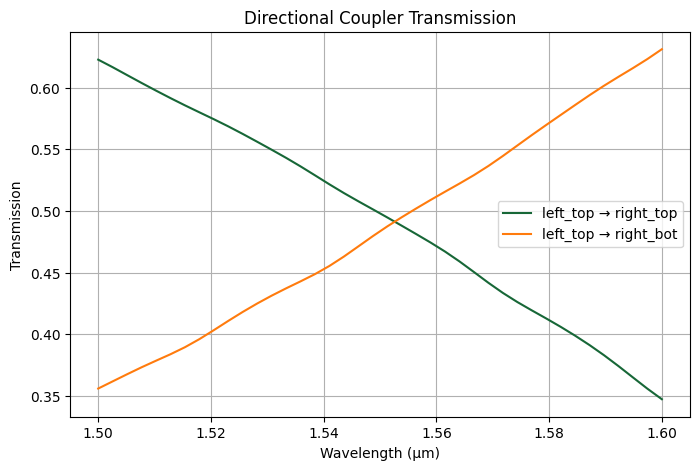

In [12]:
T_top_to_top = (
    abs(
        smatrix.loc[
            dict(port_in="left_top", mode_index_in=0, port_out="right_top", mode_index_out=0)
        ]
    )
    ** 2
)
T_top_to_bot = (
    abs(
        smatrix.loc[
            dict(port_in="left_top", mode_index_in=0, port_out="right_bot", mode_index_out=0)
        ]
    )
    ** 2
)

plt.figure(figsize=(8, 5))
plt.plot(lambda_range, T_top_to_top, label="left_top → right_top")
plt.plot(lambda_range, T_top_to_bot, label="left_top → right_bot")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission")
plt.title("Directional Coupler Transmission")
plt.legend()
plt.grid(True)

plt.show()

We can inspect the matrix `S` at a single frequency `S` and note that the diagonal elements are very small indicating low backscattering. Summing each rows of the matrix should give 1.0 if no power was lost.

In [13]:
S = np.squeeze(smatrix.sel(f=freq0, method="nearest").values)
np.sum(abs(S) ** 2, axis=0)

array([0.98372448, 0.98372449, 0.98332856, 0.98332859])

There is a little power loss since the coupler was not optimized, most likely scattering from the bends and coupling region.

Finally, we can check whether `S` is close to unitary as expected. S times its Hermitian conjugate should be the identity matrix.

In [14]:
mat = S @ (np.conj(S.T))

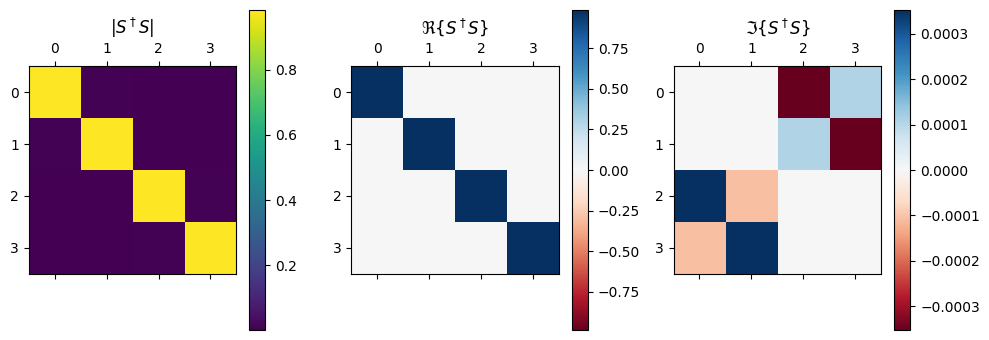

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3.5))
imabs = ax1.matshow(abs(mat))
vmax = np.abs(mat.real).max()
imreal = ax2.matshow(mat.real, cmap="RdBu", vmin=-vmax, vmax=vmax)
vmax = np.abs(mat.imag).max()
imimag = ax3.matshow(mat.imag, cmap="RdBu", vmin=-vmax, vmax=vmax)
ax1.set_title(r"$|S^\dagger S|$")
ax2.set_title(r"$\Re\{S^\dagger S\}$")
ax3.set_title(r"$\Im\{S^\dagger S\}$")
plt.colorbar(imabs, ax=ax1)
plt.colorbar(imreal, ax=ax2)
plt.colorbar(imimag, ax=ax3)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data. For that, we can use `modeler_data.data`, which stores a dictionary mapping for each port and mode to a regular FDTD [SimulationData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object.

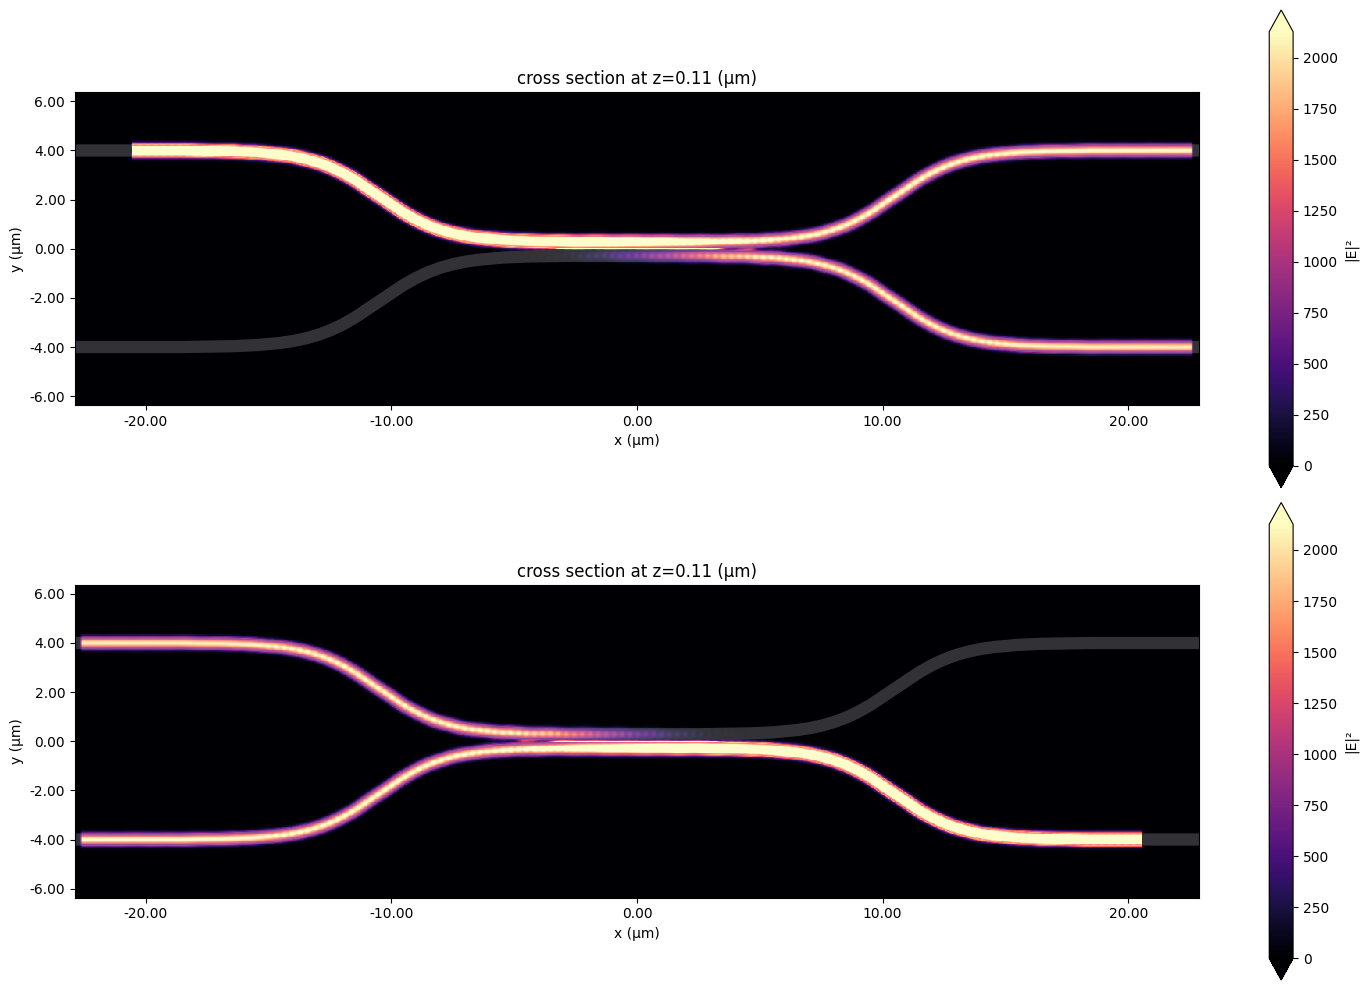

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = modeler_data.data["left_top@0"].plot_field(
    "field", field_name="E", val="abs^2", z=wg_height / 2, ax=ax1
)
ax2 = modeler_data.data["right_bot@0"].plot_field(
    "field", field_name="E", val="abs^2", z=wg_height / 2, ax=ax2
)

## Element Mappings

If we wish, we can specify mappings between scattering matrix elements that we want to be equal up to a multiplicative factor.
We can define these as `element_mappings` in the `ComponentModeler`.

"Indices" are defined as a tuple of `(port_name: str, mode_index: int)`

"Elements" are defined as a tuple of output and input indices, respectively.

The element mappings are therefore defined as a tuple of `(element, element, value)` where the second `element` is set by the value of the 1st `element` times the supplied `value`.

As an example, let's define this element mapping from the example above to enforce that the coupling between bottom left to bottom right should be equal to the coupling between top left to top right.

In [17]:
# these are the "indices" in our scattering matrix
left_top = ("left_top", 0)
right_top = ("right_top", 0)
left_bot = ("left_bot", 0)
right_bot = ("right_bot", 0)

# we define the scattering matrix elements coupling the top ports and bottom ports as pairs of these indices
top_coupling_r2l = (left_top, right_top)
bot_coupling_r2l = (left_bot, right_bot)
top_coupling_l2r = (right_top, left_top)
bot_coupling_l2r = (right_bot, left_bot)

# map the top coupling to the bottom coupling with a multiplicative factor of +1
map_horizontal_l2r = (top_coupling_l2r, bot_coupling_l2r, +1)
map_horizontal_r2l = (top_coupling_r2l, bot_coupling_r2l, +1)

element_mappings = (map_horizontal_l2r, map_horizontal_r2l)

In [18]:
# run the component modeler again
modeler = ModalComponentModeler(
    simulation=sim,
    ports=ports,
    freqs=freqs,
    element_mappings=element_mappings,
)
modeler_data = web.run(modeler, task_name="directional coupler with mappings", verbose=True)
smatrix = modeler_data.smatrix()

09:54:44 EDT Created task 'directional coupler with mappings' with resource_id  
             'sid-c99bec65-c574-47c2-b484-5f46e6d48856' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=871308;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=919321;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\taskId]8;;\]8;id=871308;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\=]8;;\]8;id=520220;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\sid]8;;\]8;id=871308;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\-c99bec65-c574]8;;\
             ]8;id=871308;https://tidy3d.simulation.cloud/workbench?taskId=sid-c99bec65-c574-47c2-b484-5f46e6d48856\-47c2-b484-5f46e6d48856']8;;\.

             Task folder: ]8;id=794845;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

09:54:46 EDT Child simulation subtasks are being uploaded to                    
             - left_bot@0: 'rf-3397c84d-c948-41e3-9229-16fdfe5ec48c'            
             - left_top@0: 'rf-becb9048-b466-4135-b732-648ca327e67b'            
             - right_bot@0: 'rf-1b614bc1-03fe-4900-a5f4-9dbae54cb3a4'           
             - right_top@0: 'rf-c20a8bec-ce7a-4477-b0ce-3afa968e0d54'

             Validating component modeler and subtask simulations...

09:54:47 EDT Maximum FlexCredit cost: 1.930. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

             Subtasks status - directional coupler with mappings                
             Group ID: 'pa-5f1136f7-f978-488e-b706-61e3cc0da9e1'

Output()

09:55:48 EDT Modeler has finished running successfully.

Output()

09:55:55 EDT loading component modeler data from ./cm_data.hdf5

The resulting scattering matrix will have the element mappings applied, we can check this explicitly.

In [19]:
# assert that the horizontal coupling elements are exactly equal
smatrix_f0 = smatrix.sel(f=freq0, method="nearest")
LT_RT = np.squeeze(
    smatrix_f0.loc[
        dict(port_in="left_top", mode_index_in=0, port_out="right_top", mode_index_out=0)
    ]
)
LB_RB = np.squeeze(
    smatrix_f0.loc[
        dict(port_in="left_bot", mode_index_in=0, port_out="right_bot", mode_index_out=0)
    ]
)
print(f"top to top coupling       = {LT_RT:.5f}")
print(f"bottom to bottom coupling = {LB_RB:.5f}")

assert np.isclose(LT_RT, LB_RB)

top to top coupling       = -0.61577-0.34002j
bottom to bottom coupling = -0.61577-0.34002j


## Incomplete Scattering Matrix
Finally, to exclude some rows of the scattering matrix, one can supply a `run_only` parameter to the `ComponentModeler`.

`run_only` contains the scattering matrix indices that the user wants to run as a source. If any indices are excluded, they will not be run.

For example, if one wants to compute scattering matrix elements from only the ports on the left hand side, the `run_only` could be defined as follows.

In [20]:
run_only = (left_top, left_bot)
modeler = ModalComponentModeler(
    simulation=sim,
    ports=ports,
    freqs=[freq0],
    run_only=run_only,
)
modeler_data = web.run(modeler, task_name="directional coupler run only", verbose=True)
smatrix = modeler_data.smatrix()
smatrix_f0 = smatrix.sel(f=freq0, method="nearest")

             Created task 'directional coupler run only' with resource_id       
             'sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=352888;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=149378;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\taskId]8;;\]8;id=352888;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\=]8;;\]8;id=30699;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\sid]8;;\]8;id=352888;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\-7fd4ac49-7f36]8;;\
             ]8;id=352888;https://tidy3d.simulation.cloud/workbench?taskId=sid-7fd4ac49-7f36-43c1-bb71-c40a032e87e4\-43c1-bb71-c40a032e87e4']8;;\.

             Task folder: ]8;id=716997;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

09:55:56 EDT Child simulation subtasks are being uploaded to                    
             - left_bot@0: 'rf-00356e29-6410-45c2-b9f1-4c216f2a72d9'            
             - left_top@0: 'rf-013369f6-0b81-4dd7-bd69-7617095ebb09'

09:55:57 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 0.918. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

09:55:58 EDT Subtasks status - directional coupler run only                     
             Group ID: 'pa-6bad4b4a-25ad-4c3c-9941-2f97d4b17126'

Output()

09:57:16 EDT Modeler has finished running successfully.

             Billed FlexCredit cost: 0.460. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:57:20 EDT loading component modeler data from ./cm_data.hdf5

The resulting scattering matrix will have all zeros for elements corresponding to ports not included in the in `run_only` inputs.

In [21]:
s_matrix_left_top = np.squeeze(smatrix_f0.loc[dict(port_in="left_top")])

print("output from run_only port     : \n", np.abs(s_matrix_left_top.values))

assert "right_top" not in smatrix.coords["port_in"]

output from run_only port     : 
 [0.70575722 0.69541139 0.02991151 0.02848451]
